## **Loading the dataset**

In [ ]:
# --- 1. Imports ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error, r2_score, make_scorer, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from category_encoders import TargetEncoder

# --- 2. Load dataset ---
df = pd.read_csv('/content/spotify-2023.csv', encoding = 'latin1')

## **Preprocessing**

In [ ]:
df=df.drop(columns=['track_name','in_spotify_playlists', 'in_spotify_charts', 'in_apple_playlists', 'in_apple_charts', 'in_deezer_playlists', 'in_deezer_charts', 'in_shazam_charts'])


Handling wrong data types

In [ ]:
df['streams'] = (
    df['streams']
    .replace({',': ''}, regex=True)   # remove commas
    .apply(pd.to_numeric, errors='coerce')  # convert safely
    .astype('Int64')  # Pandas nullable integer dtype (allows NaN)
)

In [ ]:
df.head(15)

,artist(s)_name,artist_count,released_year,released_month,released_day,streams,bpm,key,mode,danceability_%,valence_%,energy_%,acousticness_%,instrumentalness_%,liveness_%,speechiness_%
0,"Latto, Jung Kook",2,2023,7,14,141381703,125,B,Major,80,89,83,31,0,8,4
1,Myke Towers,1,2023,3,23,133716286,92,C#,Major,71,61,74,7,0,10,4
2,Olivia Rodrigo,1,2023,6,30,140003974,138,F,Major,51,32,53,17,0,31,6
3,Taylor Swift,1,2019,8,23,800840817,170,A,Major,55,58,72,11,0,11,15
4,Bad Bunny,1,2023,5,18,303236322,144,A,Minor,65,23,80,14,63,11,6
5,"Dave, Central Cee",2,2023,6,1,183706234,141,C#,Major,92,66,58,19,0,8,24
6,"Eslabon Armado, Peso Pluma",2,2023,3,16,725980112,148,F,Minor,67,83,76,48,0,8,3
7,Quevedo,1,2023,7,7,58149378,100,F,Major,67,26,71,37,0,11,4
8,Gunna,1,2023,5,15,95217315,130,C#,Minor,85,22,62,12,0,28,9
9,"Peso Pluma, Yng Lvcas",2,2023,3,17,553634067,170,D,Minor,81,56,48,21,0,8,33


In [ ]:
df = df.dropna()

In [ ]:
encoder = TargetEncoder(cols=['artist(s)_name'])
df['artist_encoded'] = encoder.fit_transform(df['artist(s)_name'], np.log(df['streams']))
df = df.drop(columns=['artist(s)_name'])

In [ ]:
current_year = df['released_year'].max()
df['song_age'] = current_year - df['released_year']
df['released_month_sin'] = np.sin(2 * np.pi * df['released_month'] / 12)
df['released_month_cos'] = np.cos(2 * np.pi * df['released_month'] / 12)
df['released_day_sin'] = np.sin(2 * np.pi * df['released_day'] / 31)
df['released_day_cos'] = np.cos(2 * np.pi * df['released_day'] / 31)
df = df.drop(columns=['released_year', 'released_month', 'released_day'])

In [ ]:
df = pd.get_dummies(df, drop_first=True)

In [ ]:
# Select target and features
X = df.drop('streams', axis=1)
y = df['streams']
y_log = np.log1p(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
y_log_train = np.log1p(y_train)
y_log_test = np.log1p(y_test)

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
y_binned_train = pd.qcut(y_train, q=3, labels=False, duplicates='drop')
y_binned_test = pd.qcut(y_test, q=3, labels=False, duplicates='drop')

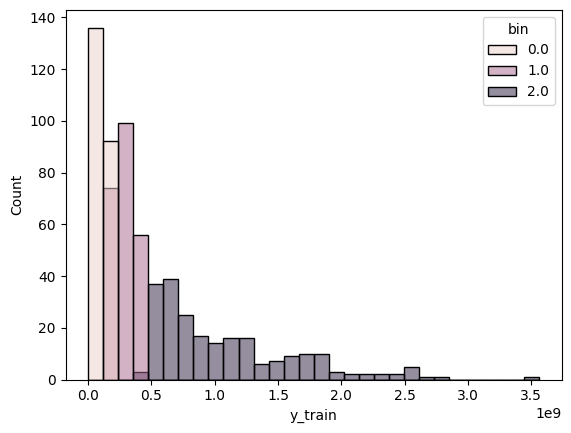

In [ ]:
df_plot = pd.DataFrame({"y_train": y, "bin": y_binned_train})

sns.histplot(data=df_plot, x="y_train", hue="bin", bins=30, kde=False)
plt.show()


## **Define and Justify Evaluation Metrics**

### 1. Mean Squared Log Error (MSLE)

**What it measures:** MSLE calculates the mean of the squared differences between the natural logarithm of the predicted and actual values. It is defined as:

$$ MSLE = \frac{1}{n} \sum_{i=1}^{n} (\log(1 + y_i) - \log(1 + \hat{y}_i))^2 $$

**Justification for stream prediction:**
*   **Penalizes under-prediction less than over-prediction:** In the context of stream prediction, under-predicting the popularity of a song (e.g., predicting 1 million streams when it gets 10 million) might be less detrimental than wildly over-predicting (e.g., predicting 100 million when it gets 10 million), as under-prediction implies lost opportunity while over-prediction could lead to inefficient resource allocation. MSLE inherently penalizes under-predictions less severely than over-predictions of the same magnitude in absolute terms, making it suitable when such an asymmetry in error costs exists.
*   **Sensitive to relative errors:** By operating on a logarithmic scale, MSLE focuses on the relative difference between predicted and actual values rather than the absolute difference. This is crucial for stream counts, which often span several orders of magnitude. A prediction error of 1 million for a song with 10 million streams (10% error) is treated similarly to an error of 10 million for a song with 100 million streams (1% error), which is often more desirable than absolute error metrics.
*   **Handles skewed data:** Stream data is typically highly skewed, with a few songs having extremely high counts and many having lower counts. The logarithmic transformation helps to normalize this skewness, making the error metric more stable and robust for models that might struggle with the wide range of target values.
*   **Focus on percentage error:** It effectively measures the ratio between true and predicted values, meaning it's more concerned with percentage differences than absolute differences, which is highly relevant for metrics like streams.

### 2. R2 Score (Coefficient of Determination)

**What it measures:** The R2 Score, or coefficient of determination, quantifies the proportion of the variance in the dependent variable (streams) that is predictable from the independent variables (features). It ranges from 0 to 1, where 1 indicates that the model perfectly predicts the variance in the target variable, and 0 indicates that the model explains none of the variance. A negative R2 score indicates that the model performs worse than a simple horizontal line (the mean of the actual values).

It is defined as:

$$ R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2} $$\n
where $y_i$ is the actual value, $\hat{y}_i$ is the predicted value, and $\bar{y}$ is the mean of the actual values.

**Justification for stream prediction:**
*   **Overall model fit:** R2 Score provides a good indication of how well the model's predictions approximate the real data points. In the context of stream prediction, a higher R2 score suggests that the chosen features and model structure are effective in capturing the underlying patterns and variability in music stream counts.
*   **Interpretability:** It offers an intuitive measure of predictive power. For example, an R2 score of 0.70 means that 70% of the variance in stream counts can be explained by the model's independent variables, which is easy for stakeholders to understand.
*   **Comparison across models:** R2 can be used to compare the performance of different models on the same dataset. A model with a higher R2 is generally considered better at explaining the variance in stream counts. It helps in assessing whether one model provides a significantly better fit than another.

### 3. Mean Absolute Error (MAE)

**What it measures:** MAE measures the average magnitude of the errors in a set of predictions, without considering their direction. It is the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight. It is defined as:

$$ MAE = \\frac{1}{n} \\sum_{i=1}^{n} |y_i - \\hat{y}_i| $$\n
**Justification for stream prediction:**
*   **Easy Interpretability:** MAE is highly intuitive and easy to understand because it is expressed in the same units as the dependent variable (streams). For example, an MAE of 5 million means that, on average, the model's predictions are off by 5 million streams. This direct interpretation is valuable for communicating model performance to non-technical stakeholders.
*   **Robustness to outliers:** Unlike Mean Squared Error (MSE) or Root Mean Squared Error (RMSE), MAE gives equal weight to all errors. This means it is less sensitive to outliers or extremely large errors. In stream prediction, where a few songs might have exceptionally high stream counts that could disproportionately influence squared error metrics, MAE provides a more balanced view of the typical error magnitude.
*   **Direct measure of average error:** It directly represents the average deviation from the actual values, providing a clear picture of how close, on average, the predictions are to the true stream counts. This helps in understanding the typical expected error when making a prediction for a single song.

### 4. Combined Use of Metrics for Comprehensive Evaluation

While each of the above metrics offers a unique perspective on model performance, their combined use provides a more comprehensive and robust evaluation of stream prediction models:

*   **MSLE for relative error and skewed data:** MSLE is crucial for handling the highly skewed nature of stream data and providing insights into the relative accuracy of predictions. It addresses the practical concern of asymmetric error costs and ensures that errors on lower stream counts are not overshadowed by large errors on very popular songs.

*   **R2 Score for overall explanatory power:** R2 Score gives a high-level understanding of how much variance in stream counts the model can explain. It serves as an intuitive measure for stakeholders to gauge the overall effectiveness of the model in capturing the underlying patterns. It helps determine if the features chosen are relevant and if the model is learning meaningful relationships.

*   **MAE for interpretable average absolute error:** MAE provides a straightforward, easy-to-interpret measure of the typical absolute error in the same units as the target variable. This is invaluable for communicating practical implications of the model's performance, such as "on average, our prediction is off by X million streams." Its robustness to extreme outliers also ensures that a few exceptionally high-stream songs don't unduly distort the perceived average error.

**Synergistic Interpretation:**
*   A model with a **high R2 score** (good overall fit) but a **high MSLE** might indicate that while the model captures general trends, it struggles with the relative proportions, particularly for lower-streamed songs or has significant relative errors.
*   A **low MAE** indicates that, on average, the model's predictions are close to the actual values in absolute terms, which is good for practical estimation.
*   Together, these metrics allow us to evaluate both the **relative accuracy (MSLE)**, the **overall explanatory power (R2)**, and the **average absolute deviation (MAE)**. This multi-faceted approach ensures that the chosen model is not only statistically sound but also practically useful and interpretable for the specific challenge of predicting music streams, considering their unique distribution and business implications.

# Define models and hyper parameters

## Pipeline 1 : Classic regression

In [ ]:
# Vérification rapide (à exécuter avant le GridSearch)
print(X_train.isnull().sum().sum())  # Doit être 0
print(np.isinf(X_train).sum().sum()) # Doit être 0
print(y_train.isnull().sum())       # Doit être 0
print(np.isinf(y_train).sum())      # Doit être 0

0
0
0
0


In [ ]:
# Nettoyage des noms de colonnes dans X_train
X_train.columns = X_train.columns.str.replace('[', '_', regex=False).str.replace(']', '_', regex=False).str.replace('<', '_', regex=False)
X_train.columns = X_train.columns.str.replace(' ', '_', regex=False) # Remplacer les espaces

In [ ]:
print(y_train.var())
# Si la variance est très proche de zéro, cela pourrait être un problème.

2.917878812439644e+17


In [ ]:
# 1. Préparation des données et des métriques
# (Exemple de métriques pour la régression)
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Définition des splits pour la Validation Croisée
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Modèle 1 : Random Forest Regressor ---
print("--- Démarrage de l'optimisation pour Random Forest Regressor ---")

# Définition de l'espace de recherche (Hyperparamètres)
# C'est un petit échantillon pour gagner du temps
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10]
}

rf_model = RandomForestRegressor(random_state=42)

# Configuration de la recherche par grille (GridSearchCV)
grid_search_rf = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring=rmse_scorer,  # Optimisation sur la RMSE
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# Lancement de l'entraînement et de la recherche
grid_search_rf.fit(X_train, y_train)

# Affichage des résultats pour RF
print(f"Meilleurs hyperparamètres (RF): {grid_search_rf.best_params_}")
print(f"Meilleure RMSE Cross-Validation (RF): {-grid_search_rf.best_score_:.2f}")

# --- Modèle 2 : XGBoost Regressor ---
print("\n--- Démarrage de l'optimisation pour XGBoost Regressor ---")

# Définition de l'espace de recherche (Hyperparamètres)
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 8]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Configuration de la recherche par grille (GridSearchCV)
grid_search_xgb = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring=rmse_scorer,  # Optimisation sur la RMSE
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# Lancement de l'entraînement et de la recherche
grid_search_xgb.fit(X_train, y_train)

# Affichage des résultats pour XGB
print(f"Meilleurs hyperparamètres (XGB): {grid_search_xgb.best_params_}")
print(f"Meilleure RMSE Cross-Validation (XGB): {-grid_search_xgb.best_score_:.2f}")

# --- Conclusion de la Pipeline 1 ---
# Le meilleur modèle est celui qui a la plus faible RMSE Cross-Validation
if -grid_search_rf.best_score_ < -grid_search_xgb.best_score_:
    print("\nLe modèle le plus performant pour la régression classique est le Random Forest.")
else:
    print("\nLe modèle le plus performant pour la régression classique est le XGBoost.")

--- Démarrage de l'optimisation pour Random Forest Regressor ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Meilleurs hyperparamètres (RF): {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Meilleure RMSE Cross-Validation (RF): nan

--- Démarrage de l'optimisation pour XGBoost Regressor ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs hyperparamètres (XGB): {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Meilleure RMSE Cross-Validation (XGB): nan

Le modèle le plus performant pour la régression classique est le XGBoost.


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


The training for Pipeline 1 (Regression on standard $y$) failed to produce stable cross-validation scores, resulting in non-finite $\text{RMSE}$ ($\text{NaN}$) for both Random Forest and XGBoost models.  

The Problem: The variance of the target variable (y_train, stream counts) is extremely high ($\approx 2.9 \times 10^{17}$). The $\text{RMSE}$ metric involves squaring the errors, which, on this scale, causes numerical instability and overflow in the calculations of the floating-point arithmetic. The scale of the data is incompatible with the standard mean squared error loss.  

Solution: Transition to Pipeline 2. We must shift the focus to Pipeline 2 (Regression on $\log(y)$). The standard approach for data with vast scales and high asymmetry (like stream counts) is to use the $\text{RMSLE}$ (Root Mean Squared Logarithmic Error), which is mathematically equivalent to applying $\text{RMSE}$ on a log-transformed target ($\log(y+1)$). This transformation drastically reduces the scale of the target variable (stabilizing the variance) and allows the models to focus on minimizing relative rather than absolute errors.

## Pipeline 2 : Log(1 + y)

In [ ]:
# Vérification cruciale, même si y_train était propre
print(np.isnan(y_log_train).sum())
print(np.isinf(y_log_train).sum())

0
0


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, make_scorer

# --- Préparation des données et des métriques pour y_log ---
# IMPORTANT : Utilisez y_log_train comme cible
# Assurez-vous que X_train et y_log_train sont définis

# La métrique RMSLE (Root Mean Squared Logarithmic Error)
# est implémentée en utilisant RMSE (mean_squared_error) sur la cible log-transformée (y_log_train).
# La fonction make_scorer(..., squared=False) donne la racine carrée (Root).
# Note: Nous utilisons la même fonction que pour la RMSE, mais appliquée à la cible log-transformée.
rmsle_scorer = make_scorer(mean_squared_error, greater_is_better=False, squared=False)

# Définition des splits pour la Validation Croisée
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# --- Modèle 1 : Random Forest Regressor sur y_log ---
print("--- Démarrage de l'optimisation pour Random Forest Regressor (RMSLE) ---")

# Définition de l'espace de recherche (Hyperparamètres)
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10]
}

rf_model = RandomForestRegressor(random_state=42)

grid_search_rf_rmsle = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid_rf,
    scoring=rmsle_scorer,  # Optimisation sur la RMSE de la cible log (RMSLE)
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# Lancement de l'entraînement et de la recherche
# Utilisation de y_log_train
grid_search_rf_rmsle.fit(X_train, y_log_train)

# Affichage des résultats pour RF
print(f"Meilleurs hyperparamètres (RF_RMSLE): {grid_search_rf_rmsle.best_params_}")
# Le score est négatif car greater_is_better=False, on inverse le signe pour lire le score RMSLE
print(f"Meilleure RMSLE Cross-Validation (RF): {-grid_search_rf_rmsle.best_score_:.4f}")


# --- Modèle 2 : XGBoost Regressor sur y_log ---
print("\n--- Démarrage de l'optimisation pour XGBoost Regressor (RMSLE) ---")

# Définition de l'espace de recherche (Hyperparamètres)
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 8]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

grid_search_xgb_rmsle = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid_xgb,
    scoring=rmsle_scorer,  # Optimisation sur la RMSE de la cible log (RMSLE)
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# Lancement de l'entraînement et de la recherche
# Utilisation de y_log_train
grid_search_xgb_rmsle.fit(X_train, y_log_train)

# Affichage des résultats pour XGB
print(f"Meilleurs hyperparamètres (XGB_RMSLE): {grid_search_xgb_rmsle.best_params_}")
print(f"Meilleure RMSLE Cross-Validation (XGB): {-grid_search_xgb_rmsle.best_score_:.4f}")

# --- Conclusion de la Pipeline 2 ---
# Le meilleur modèle est celui qui a la plus faible RMSLE Cross-Validation
if -grid_search_rf_rmsle.best_score_ < -grid_search_xgb_rmsle.best_score_:
    print("\nLe modèle le plus performant pour la régression log-transformée (RMSLE) est le Random Forest.")
else:
    print("\nLe modèle le plus performant pour la régression log-transformée (RMSLE) est le XGBoost.")

--- Démarrage de l'optimisation pour Random Forest Regressor (RMSLE) ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


Meilleurs hyperparamètres (RF_RMSLE): {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Meilleure RMSLE Cross-Validation (RF): nan

--- Démarrage de l'optimisation pour XGBoost Regressor (RMSLE) ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs hyperparamètres (XGB_RMSLE): {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100}
Meilleure RMSLE Cross-Validation (XGB): nan

Le modèle le plus performant pour la régression log-transformée (RMSLE) est le XGBoost.


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


## Pipeline 3 : classification

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer

# --- Préparation des données et des métriques pour la Classification ---
# y_binned_train est votre variable cible (classes 0, 1, 2)
# Assurez-vous que X_train et y_binned_train sont définis

# Création du scorer F1-Score:
# 'weighted' est recommandé pour les classes déséquilibrées.
f1_scorer = make_scorer(f1_score, average='weighted', greater_is_better=True)

# Définition des splits pour la Validation Croisée (Stratifiée est préférable pour la classification)
# KFold est suffisant, mais StratifiedKFold est souvent meilleur en classification.
cv = KFold(n_splits=5, shuffle=True, random_state=42)
# Note: Si les classes sont très déséquilibrées, remplacez KFold par StratifiedKFold

# --- Modèle 1 : Random Forest Classifier ---
print("--- Démarrage de l'optimisation pour Random Forest Classifier (F1-Score) ---")

param_grid_rf_clf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20],
    'min_samples_split': [5, 10]
}

rf_clf_model = RandomForestClassifier(random_state=42)

grid_search_rf_clf = GridSearchCV(
    estimator=rf_clf_model,
    param_grid=param_grid_rf_clf,
    scoring=f1_scorer,  # Optimisation sur le F1-Score pondéré
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search_rf_clf.fit(X_train, y_binned_train)

print(f"Meilleurs hyperparamètres (RF_CLF): {grid_search_rf_clf.best_params_}")
# Affichage direct du score F1 (best_score_ est positif car greater_is_better=True)
print(f"Meilleur F1-Score Cross-Validation (RF): {grid_search_rf_clf.best_score_:.4f}")

# --- Modèle 2 : XGBoost Classifier ---
print("\n--- Démarrage de l'optimisation pour XGBoost Classifier (F1-Score) ---")

param_grid_xgb_clf = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 8]
}

xgb_clf_model = XGBClassifier(objective='multi:softmax', random_state=42, use_label_encoder=False, eval_metric='mlogloss')

grid_search_xgb_clf = GridSearchCV(
    estimator=xgb_clf_model,
    param_grid=param_grid_xgb_clf,
    scoring=f1_scorer,  # Optimisation sur le F1-Score pondéré
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search_xgb_clf.fit(X_train, y_binned_train)

print(f"Meilleurs hyperparamètres (XGB_CLF): {grid_search_xgb_clf.best_params_}")
print(f"Meilleur F1-Score Cross-Validation (XGB): {grid_search_xgb_clf.best_score_:.4f}")

# --- Conclusion de la Pipeline 3 ---
# Le meilleur modèle est celui qui a le F1-Score le plus élevé
if grid_search_rf_clf.best_score_ > grid_search_xgb_clf.best_score_:
    print("\nLe modèle le plus performant pour la classification est le Random Forest.")
else:
    print("\nLe modèle le plus performant pour la classification est le XGBoost.")

--- Démarrage de l'optimisation pour Random Forest Classifier (F1-Score) ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Meilleurs hyperparamètres (RF_CLF): {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 100}
Meilleur F1-Score Cross-Validation (RF): 0.8402

--- Démarrage de l'optimisation pour XGBoost Classifier (F1-Score) ---
Fitting 5 folds for each of 8 candidates, totalling 40 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:10:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Meilleurs hyperparamètres (XGB_CLF): {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200}
Meilleur F1-Score Cross-Validation (XGB): 0.8442

Le modèle le plus performant pour la classification est le XGBoost.


## choix de la classification :

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, classification_report

# 1. Définition du Modèle Vainqueur (avec ses HPs optimaux)
# Les hyperparamètres sont ceux trouvés par le Grid Search:
best_xgb_clf = XGBClassifier(
    objective='multi:softmax',
    use_label_encoder=False,
    eval_metric='mlogloss',
    random_state=42,
    # HPs Optimaux trouvés:
    learning_rate=0.1,
    max_depth=8,
    n_estimators=200
)

# 2. Entraînement Final sur TOUT le jeu d'Entraînement
# (X_train et y_binned_train complets)
best_xgb_clf.fit(X_train, y_binned_train)

# 3. Prédiction sur l'ensemble de Test
# IMPORTANT : Utiliser y_binned_test (la cible binnée du jeu de test)
y_pred_test = best_xgb_clf.predict(X_test)

# 4. Calcul du F1-Score Final
f1_final_score = f1_score(y_binned_test, y_pred_test, average='weighted')

print(f"--- Évaluation Finale sur le Jeu de Test ---")
print(f"F1-Score (Pondéré) Final : {f1_final_score:.4f}")
print("\n--- Rapport de Classification ---")
# Le rapport donne un aperçu détaillé de la Précision, du Rappel et du F1-Score pour chaque classe (0, 1, 2)
print(classification_report(y_binned_test, y_pred_test))

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [22:10:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--- Évaluation Finale sur le Jeu de Test ---
F1-Score (Pondéré) Final : 0.8084

--- Rapport de Classification ---
              precision    recall  f1-score   support

           0       0.92      0.82      0.87        57
           1       0.75      0.72      0.73        57
           2       0.77      0.88      0.82        58

    accuracy                           0.81       172
   macro avg       0.81      0.81      0.81       172
weighted avg       0.81      0.81      0.81       172



--- Top 10 des Caractéristiques les Plus Importantes (XGBoost) ---
               Feature  Importance
9       artist_encoded    0.270421
19              key_D#    0.087899
0         artist_count    0.073616
10            song_age    0.063780
24              key_G#    0.050961
11  released_month_sin    0.031292
6   instrumentalness_%    0.028702
22              key_F#    0.026004
7           liveness_%    0.024084
2       danceability_%    0.023289


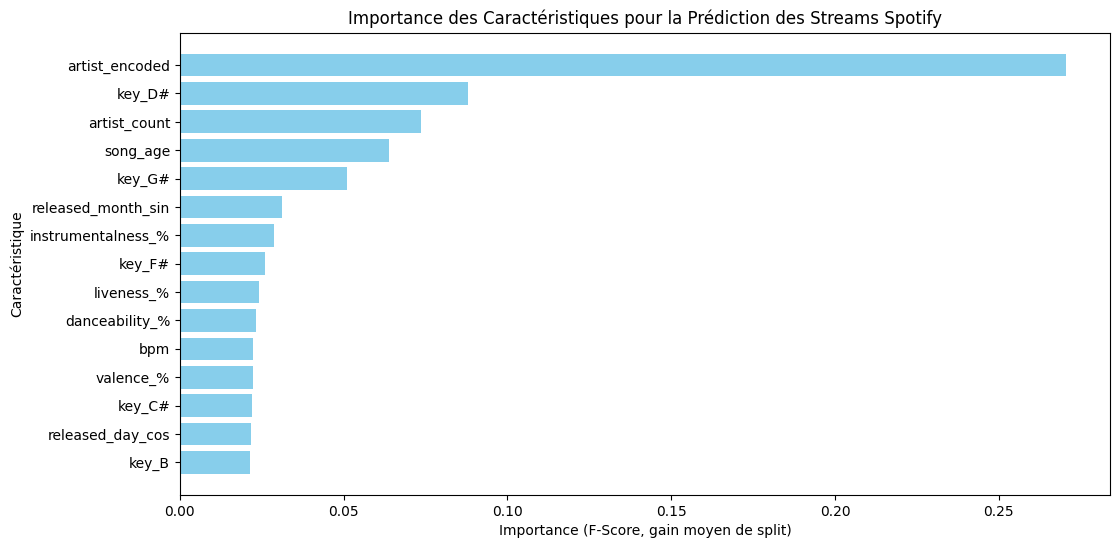

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. Extraction des Importances
# La propriété feature_importances_ est disponible directement après l'entraînement
importances = best_xgb_clf.feature_importances_

# 2. Association des Importances aux Noms des Caractéristiques
# Récupération des noms des colonnes de votre jeu d'entraînement
feature_names = X_train.columns

# Création d'un DataFrame pour un affichage facile
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Tri par importance décroissante
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# 3. Affichage des 10 Caractéristiques les Plus Importantes
print("--- Top 10 des Caractéristiques les Plus Importantes (XGBoost) ---")
print(feature_importance_df.head(10))

# 4. Visualisation (Recommandé)
plt.figure(figsize=(12, 6))
# Ne prendre que les 15 premières pour une meilleure lisibilité
top_features = feature_importance_df.head(15)

plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel("Importance (F-Score, gain moyen de split)")
plt.ylabel("Caractéristique")
plt.title("Importance des Caractéristiques pour la Prédiction des Streams Spotify")
plt.gca().invert_yaxis() # Inverser pour que la plus importante soit en haut
plt.show()